Author: Jonathan Lim \
Email: Jonathanlimws@gmail.com


# Get Data  

**Definition**

Pairs trading is a non-directional, relative value investment strategy that seeks to identify 2 companies or funds with similar characteristics whose equity securities are currently trading at a price relationship that is out of their historical trading range.

**Outline of Project**

The focus of this project is to finding the best pairs of stocks to trade given a stock universe. I will be using 50% of s&p500 stocks as I am limited by the number of stocks I can download from Financial Modelling Prep API.

I will import stock metadata from DataHub.io.

Using DBSCAN, the best pairs will be identified and then visualised using t-sne.


In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from statsmodels.tsa.stattools import coint

import numpy as np
import pandas as pd
import requests
import io
from scipy import stats


# Downloading S&P500 Stock Ticker Sector
url = "https://pkgstore.datahub.io/core/s-and-p-500-companies-financials/constituents_json/data/5ec6b99955047958b093bddd64df4bba/constituents_json.json" # Make sure the url is the raw version of the file on GitHub
url2='https://pkgstore.datahub.io/core/s-and-p-500-companies-financials/constituents-financials_json/data/ddf1c04b0ad45e44f976c1f32774ed9a/constituents-financials_json.json'
stock_info_df = pd.read_json(url2)

stock_info_df = stock_info_df.drop(columns = ['Name','SEC Filings'])

stock_info_df.head()

,52 Week High,52 Week Low,Dividend Yield,EBITDA,Earnings/Share,Market Cap,Price,Price/Book,Price/Earnings,Price/Sales,Sector,Symbol
0,175.490,259.77,2.332862,9.048000e+09,7.92,138721055226,222.89,11.34,24.31,4.390271,Industrials,MMM
1,48.925,68.39,1.147959,6.010000e+08,1.70,10783419933,60.24,6.35,27.76,3.575483,Industrials,AOS
2,42.280,64.60,1.908982,5.744000e+09,0.26,102121042306,56.27,3.19,22.51,3.740480,Health Care,ABT
3,60.050,125.86,2.499560,1.031000e+10,3.29,181386347059,108.48,26.14,19.41,6.291571,Health Care,ABBV
4,114.820,162.60,1.714470,5.643228e+09,5.44,98765855553,150.51,10.62,25.47,2.604117,Information Technology,ACN


In [23]:
#remove stocks without sector information 
stock_info_df = stock_info_df[stock_info_df['Sector']!=None]

print(stock_info_df.shape)

#replace categorical data with numerical scores
sector_dict = {'Industrials'              :1,
               'Health Care'              :2,
               'Information Technology'   :3,
               'Consumer Staples'         :4,
               'Utilities'                :5,
               'Financials'               :6, 
               'Real Estate'              :7,
               'Materials'                :8,
               'Consumer Discretionary'   :9,
               'Energy'                   :10,
               'Telecommunication Services':11,}

stock_info_df = stock_info_df.replace({'Sector': sector_dict})

#remove columns not listed within given time frame
stock_info_df = stock_info_df.dropna(axis=1, how='all')

#remove any row with NaN data
stock_info_df.drop(stock_info_df[stock_info_df.isnull().any(axis=1)].index, axis=0, inplace=True)

#get list of tickers + lower caps 
tickers_list = list(stock_info_df['Symbol'].unique())

(505, 12)


In [86]:
print(stock_info_df.shape)
stock_info_df.head()

(495, 12)


,52 Week High,52 Week Low,Dividend Yield,EBITDA,Earnings/Share,Market Cap,Price,Price/Book,Price/Earnings,Price/Sales,Sector,Symbol
0,175.490,259.77,2.332862,9.048000e+09,7.92,138721055226,222.89,11.34,24.31,4.390271,1,MMM
1,48.925,68.39,1.147959,6.010000e+08,1.70,10783419933,60.24,6.35,27.76,3.575483,1,AOS
2,42.280,64.60,1.908982,5.744000e+09,0.26,102121042306,56.27,3.19,22.51,3.740480,2,ABT
3,60.050,125.86,2.499560,1.031000e+10,3.29,181386347059,108.48,26.14,19.41,6.291571,2,ABBV
4,114.820,162.60,1.714470,5.643228e+09,5.44,98765855553,150.51,10.62,25.47,2.604117,3,ACN


## Financial Model Prepping


In [73]:
import json
from urllib.request import urlopen
from tqdm import tqdm

#loading json file from Financial Modelling Prep API
api = "c561b61d9e53df2c93da58ebfff8022c"

#initiate variables
tickers_adjClose_df = pd.DataFrame()
missing_ticker_counter = 0

for index,ticker in enumerate(tqdm(tickers_list[0:250])):
    
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?apikey={api}"
    
    #dates
    start_date = "2020-10-18"
    end_date = "2022-10-18"
    
    #load json data
    response = urlopen(url)
    data = response.read().decode("utf-8")
    quote_stock = json.loads(data)
    
    #check if dictionary is empty (i.e. if the stock data exist )
    if not bool(quote_stock):
        print(f"{ticker} stock data missing on FMP API.")
        missing_ticker_counter += 1
    else:
        #shift nested dictionary to get proper dataframe
        ## For given Columns shift out of nested dictionary
        headers = ['date','adjClose'] 
        
        #iterate through all time-series
        for i in range(len(quote_stock['historical'])):
            for header in headers:
                if i == 0:
                    quote_stock[header] = [quote_stock['historical'][i][header]]
                    del quote_stock['historical'][i][header]
                else:
                    quote_stock[header].append(quote_stock['historical'][i][header])
                    del quote_stock['historical'][i][header]
        
        #remove unneccesary columns
        del quote_stock['historical']
        del quote_stock['symbol']

        df = pd.DataFrame.from_dict(quote_stock)

        #rename column to ticker name
        adjClose_df = df.rename(columns={'adjClose':ticker})

        #get specific dates
        adjClose_df["date"] = pd.to_datetime(df["date"])
        adjClose_df = adjClose_df.loc[(adjClose_df['date'] > start_date) & (adjClose_df['date'] <= end_date)]

        if index==0:
            tickers_adjClose_df = pd.concat([adjClose_df,tickers_adjClose_df])
        else:
            tickers_adjClose_df = pd.merge(tickers_adjClose_df,adjClose_df,on='date',how='left')

  9%|▉         | 44/495 [00:41<06:10,  1.22it/s]

APC stock data missing on FMP API.


 17%|█▋        | 85/495 [01:20<04:37,  1.48it/s]

COG stock data missing on FMP API.


 19%|█▉        | 94/495 [01:28<05:38,  1.19it/s]

CBG stock data missing on FMP API.


 31%|███       | 154/495 [02:24<04:30,  1.26it/s]

DWDP stock data missing on FMP API.


 31%|███▏      | 155/495 [02:24<03:50,  1.48it/s]

DPS stock data missing on FMP API.


 37%|███▋      | 183/495 [02:50<04:26,  1.17it/s]

ESRX stock data missing on FMP API.


 42%|████▏     | 209/495 [03:20<04:34,  1.04it/s]

GGP stock data missing on FMP API.


 45%|████▍     | 221/495 [03:33<04:10,  1.09it/s]

HRS stock data missing on FMP API.


 51%|█████     | 250/495 [04:07<04:02,  1.01it/s]


HTTPError: HTTP Error 403: 

In [74]:
print(tickers_adjClose_df.shape)
tickers_adjClose_df.head()

,date,MMM,AOS,ABT,ABBV,ACN,ATVI,AYI,ADBE,AAP,...,ITW,ILMN,INCY,IR,INTC,ICE,IBM,IP,IPG,IFF
0,2022-10-18,115.95,51.76,104.980000,144.600000,264.050000,72.26,175.020000,292.98,174.73,...,193.37,208.68,71.11,47.02,25.87,92.71,122.94,33.54,29.30,92.69
1,2022-10-17,113.86,51.61,103.520000,144.410000,262.220000,71.76,170.900000,293.50,169.86,...,190.97,207.11,70.36,46.73,26.42,91.78,121.52,33.23,28.30,89.65
2,2022-10-14,113.63,49.04,100.910000,142.940000,252.720000,72.13,164.940002,287.94,168.57,...,186.10,199.32,69.10,45.11,25.91,90.15,120.04,32.62,27.47,87.71
3,2022-10-13,114.26,48.86,102.470000,142.920000,257.460000,73.12,171.069992,294.74,171.58,...,190.79,202.64,68.42,46.79,26.42,92.47,121.79,32.78,27.36,87.79
4,2022-10-12,108.95,49.13,99.610001,138.569992,250.070007,73.50,167.482727,286.15,169.32,...,185.15,198.27,67.51,45.13,25.33,90.61,117.57,31.50,26.49,84.87


(503, 215)


,MMM,AOS,ABT,ABBV,ACN,ATVI,AYI,ADBE,AAP,AMD,...,ITW,ILMN,INCY,IR,INTC,ICE,IBM,IP,IPG,IFF
date,,,,,,,,,,,,,,,,,,,,,
2022-10-17,-0.018025,-0.002898,-0.013907,-0.001314,-0.006931,-0.006919,-0.023540,0.001775,-0.027872,0.000691,...,-0.012411,-0.007523,-0.010547,-0.006168,0.021260,-0.010031,-0.011550,-0.009243,-0.034130,-0.032797
2022-10-14,-0.002020,-0.049797,-0.025213,-0.010179,-0.036229,0.005156,-0.034874,-0.018944,-0.007594,-0.034852,...,-0.025501,-0.037613,-0.017908,-0.034667,-0.019304,-0.017760,-0.012179,-0.018357,-0.029329,-0.021640
2022-10-13,0.005544,-0.003670,0.015459,-0.000140,0.018756,0.013725,0.037165,0.023616,0.017856,0.053629,...,0.025202,0.016657,-0.009841,0.037242,0.019684,0.025735,0.014578,0.004905,-0.004004,0.000912
2022-10-12,-0.046473,0.005526,-0.027911,-0.030437,-0.028703,0.005197,-0.020970,-0.029144,-0.013172,-0.018493,...,-0.029561,-0.021565,-0.013300,-0.035478,-0.041257,-0.020115,-0.034650,-0.039048,-0.031798,-0.033261
2022-10-11,-0.001010,0.003664,0.016687,0.010930,0.007158,0.000680,-0.007338,-0.004613,-0.002717,-0.003803,...,0.004753,0.004489,-0.003851,0.006426,-0.011449,0.001987,0.001956,0.002540,-0.012080,0.020384


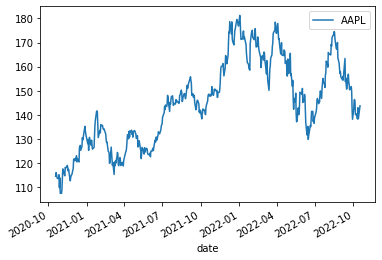

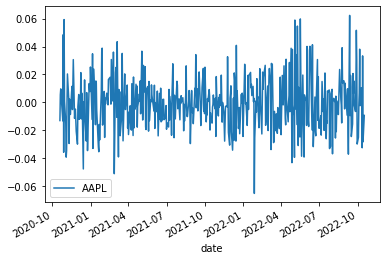

In [108]:
# #set date as index
# tickers_adjClose_df = tickers_adjClose_df.set_index('date')
tickers_adjClose_df[['AAPL']].plot();

#get percentage change 
returns = tickers_adjClose_df.pct_change()
returns[['AAPL']].plot();

#keep companies only with full data 
returns = returns.iloc[1:,:].dropna(axis=1)
print(returns.shape)
returns.head()

In [94]:
#keep stock_info for stocks downloaded
dwnled_stocks = list(returns.columns)
metadata_stock_df = stock_info_df[stock_info_df['Symbol'].isin(dwnled_stocks)]
print(metadata_stock_df.shape)
metadata_stock_df.head()

(215, 12)


,52 Week High,52 Week Low,Dividend Yield,EBITDA,Earnings/Share,Market Cap,Price,Price/Book,Price/Earnings,Price/Sales,Sector,Symbol
0,175.490,259.77,2.332862,9.048000e+09,7.92,138721055226,222.89,11.34,24.31,4.390271,1,MMM
1,48.925,68.39,1.147959,6.010000e+08,1.70,10783419933,60.24,6.35,27.76,3.575483,1,AOS
2,42.280,64.60,1.908982,5.744000e+09,0.26,102121042306,56.27,3.19,22.51,3.740480,2,ABT
3,60.050,125.86,2.499560,1.031000e+10,3.29,181386347059,108.48,26.14,19.41,6.291571,2,ABBV
4,114.820,162.60,1.714470,5.643228e+09,5.44,98765855553,150.51,10.62,25.47,2.604117,3,ACN


# Implementing DBScan Clustering 

In [99]:
metadata_stock_df.head()

,52 Week High,52 Week Low,Dividend Yield,EBITDA,Earnings/Share,Market Cap,Price,Price/Book,Price/Earnings,Price/Sales,Sector,Symbol
0,175.490,259.77,2.332862,9.048000e+09,7.92,138721055226,222.89,11.34,24.31,4.390271,1,MMM
1,48.925,68.39,1.147959,6.010000e+08,1.70,10783419933,60.24,6.35,27.76,3.575483,1,AOS
2,42.280,64.60,1.908982,5.744000e+09,0.26,102121042306,56.27,3.19,22.51,3.740480,2,ABT
3,60.050,125.86,2.499560,1.031000e+10,3.29,181386347059,108.48,26.14,19.41,6.291571,2,ABBV
4,114.820,162.60,1.714470,5.643228e+09,5.44,98765855553,150.51,10.62,25.47,2.604117,3,ACN


In [119]:
#check that order of two rows are the same (for later np.hstack)
list(returns.columns) == list(metadata_stock_df.Symbol)

True

In [137]:
#### from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

#Principal Component Analysis
#
variance = 0.5
pca = PCA(n_components = variance)
pca.fit(returns)

#Assuming similar indexing of stokcs
X = np.hstack((pca.components_.T,
               metadata_stock_df[['Sector']],
               metadata_stock_df[['52 Week High']],
               metadata_stock_df[['52 Week Low']],
               metadata_stock_df[['Dividend Yield']],
               metadata_stock_df[['EBITDA']],
               metadata_stock_df[['Earnings/Share']],
               metadata_stock_df[['Market Cap']],
               metadata_stock_df[['Price/Book']]))
 
X = preprocessing.StandardScaler().fit_transform(X)
print(X.shape)

(215, 12)


deciding on parameters 
source: https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/

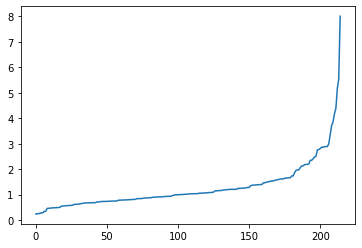

In [189]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [183]:
MinPts = X.shape[1]*2

clf = DBSCAN(eps=3, min_samples=2)
print (clf)

clf.fit(X)
clf.labels_

DBSCAN(eps=3, min_samples=2)


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,
        2,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  3,  4, -1,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,
        0,  5,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [190]:
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"\nClusters discovered: {n_clusters_}")

clustered = clf.labels_

print("_"*30)

# the initial dimensionality of the search was
ticker_count = len(returns.columns)
print ("Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2))

clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())

print("_"*30)

CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())


Clusters discovered: 7
______________________________
Total pairs possible in universe: 23005 
______________________________
Clusters formed: 7
Pairs to evaluate: 37842


# Visualising 

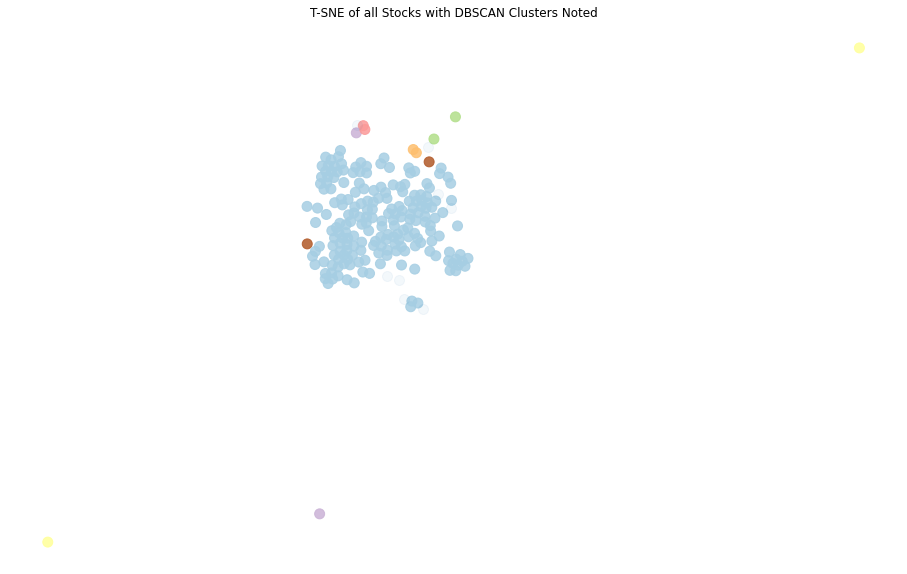

In [185]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

plt.figure(1, facecolor='white',figsize=(16,10))
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted');

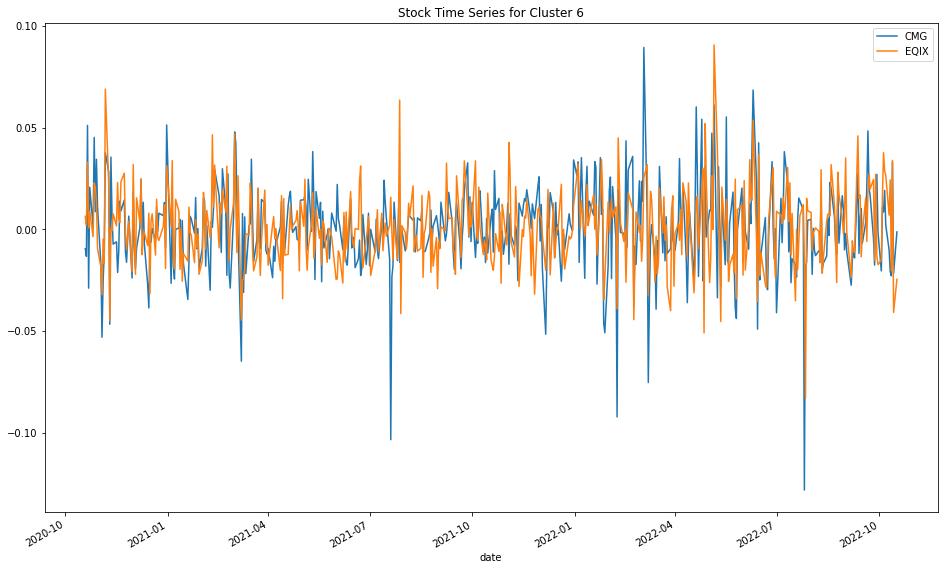

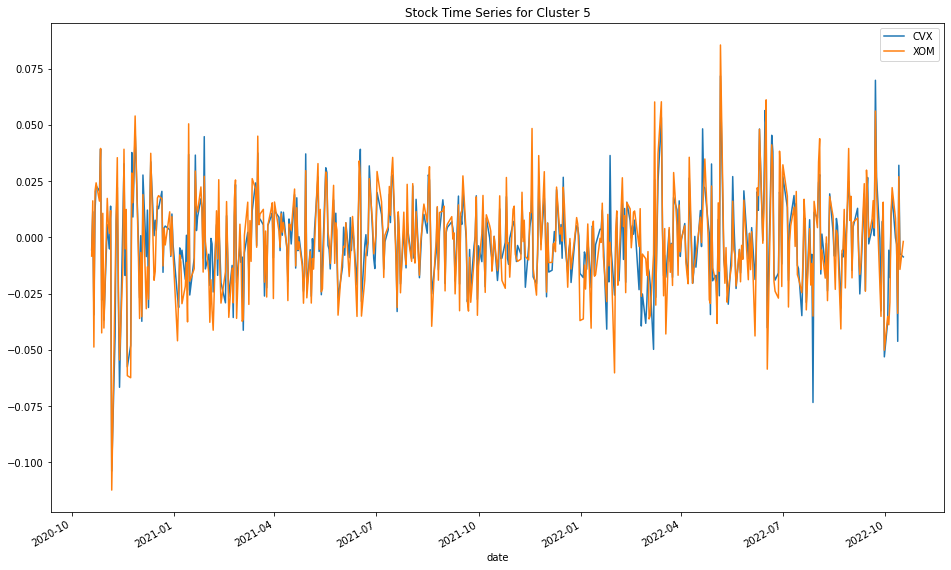

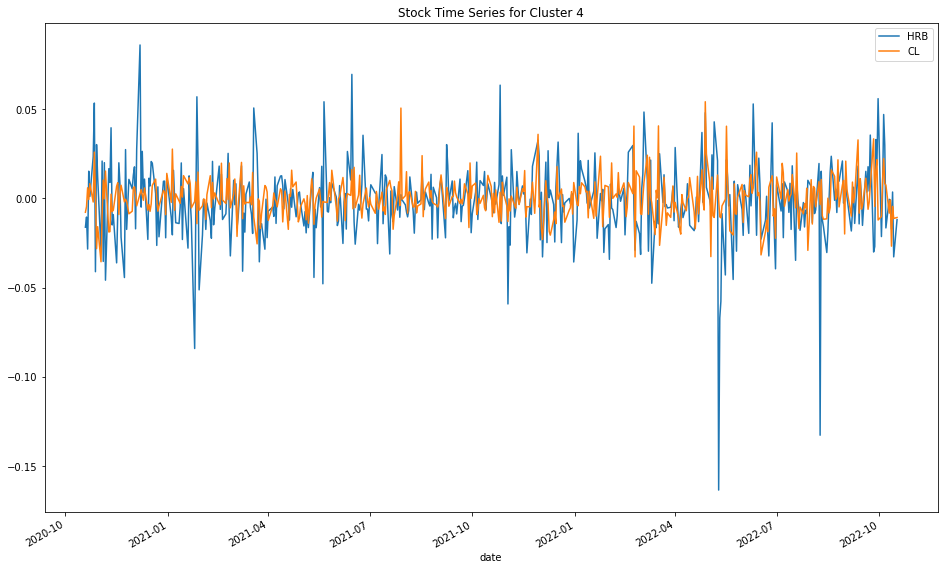

In [205]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 3)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    returns[tickers].plot(title='Stock Time Series for Cluster %d' % clust,figsize=(16,10))